<a href="https://colab.research.google.com/github/afccacador13/OpenHPI_DSBootcamp/blob/main/NB_macroeconomic_vars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew, kurtosis, kstest
from statsmodels.tsa.stattools import adfuller

In [ ]:
input_labels = pd.read_excel('DSV_BPSTAT_LABELS_IMM_IMQ_IMY.xls')
input_info = pd.read_excel('DSV_BPSTAT_SERIES_IMM_IMQ_IMY.xls')

In [ ]:
input_info

,ID_SERIE,Date,value,DATA_UPDT
0,12519781,2003-01-31,5.34,2025-01-07
1,12519781,2003-02-28,5.10,2025-01-07
2,12519781,2003-03-31,4.71,2025-01-07
3,12519781,2003-04-30,4.70,2025-01-07
4,12519781,2003-05-31,4.57,2025-01-07
...,...,...,...,...
25997,12646060,2019-12-31,1.76,2025-01-07
25998,12646060,2020-12-31,1.71,2025-01-07
25999,12646060,2021-12-31,1.71,2025-01-07
26000,12646060,2022-12-31,2.58,2025-01-07


In [ ]:
# --- Function to select variables and perform ADF ---
def adf_perform(variable_list, var, input_labels, input_info):

  results = []
  for variable in variable_list:

      # Get ID_SERIE from labels table
      match = input_labels[input_labels['Variavel'] == variable]
      if match.empty:
          print(f"Variable '{variable}' not found. Skipping.")
          continue
      variable_id = match.iloc[0]['ID_SERIE']


      # Filter time series data for that ID_SERIE
      ts_data = input_info[input_info['ID_SERIE'] == variable_id]

      if ts_data.empty:
          print(f"No data for ID_SERIE {variable_id} ({variable}). Skipping.")
          continue


      # Sort by time if needed (optional, but recommended)
      if 'date' in ts_data.columns:
          ts_data = ts_data.sort_values('date')

      series = ts_data[var].dropna()

      for lag in [0, 1, 2, 3]:
          try:
              adf_result = adfuller(series, maxlag=lag, regression='c', autolag=None)
              results.append({
                  'Variable': variable,
                  'Variable ID' : variable_id,
                  'Lag': lag,
                  'ADF Statistic': adf_result[0],
                  'p-value': adf_result[1],
                  'Used Lag': adf_result[2],
                  'N Observations': adf_result[3],
                  **{f"CV {k}": v for k, v in adf_result[4].items()}
              })
          except Exception as e:
              print(f"ADF test failed for {variable} (lag {lag}): {e}")

  return results


In [ ]:
#List of macrovariables to assess space-separated :
#1) PIB PT: PIB_PM_TVH
#2) Taxa de desemprego PT: TD_BDP
#3) EURIBOR 3, 6, 12 meses
#4) TBA: TBA_EURIBOR
#5) IPC: ?
#6) ROE_PMO: ?
#7) CUST_FIN: ?
#8) ENDIV: ?
#9) TxJurEmp: ?


variable_list = ['PIB_PM_TVH', 'TD_BDP', 'TBA_EURIBOR']

results= adf_perform(variable_list, 'value', input_labels,input_info)


# --- Save and display results ---
results_adf = pd.DataFrame(results)
results_adf

,Variable,Variable ID,Lag,ADF Statistic,p-value,Used Lag,N Observations,CV 1%,CV 5%,CV 10%
0,PIB_PM_TVH,12518314,0,-5.064321,1.652951e-05,0,114,-3.489058,-2.887246,-2.580481
1,PIB_PM_TVH,12518314,1,-4.039541,1.217046e-03,1,113,-3.489590,-2.887477,-2.580604
2,PIB_PM_TVH,12518314,2,-3.637497,5.083325e-03,2,112,-3.490131,-2.887712,-2.580730
3,PIB_PM_TVH,12518314,3,-5.732423,6.553554e-07,3,111,-3.490683,-2.887952,-2.580857
4,TD_BDP,12562676,0,-0.909027,7.849852e-01,0,187,-3.465812,-2.877123,-2.575077
5,TD_BDP,12562676,1,-1.260074,6.472351e-01,1,186,-3.466005,-2.877208,-2.575122
6,TD_BDP,12562676,2,-1.800426,3.802505e-01,2,185,-3.466201,-2.877293,-2.575168
7,TD_BDP,12562676,3,-2.043211,2.679538e-01,3,184,-3.466398,-2.877380,-2.575214
8,TBA_EURIBOR,12504602,0,-0.915264,7.829044e-01,0,309,-3.451691,-2.870939,-2.571778
9,TBA_EURIBOR,12504602,1,-1.540367,5.134562e-01,1,308,-3.451761,-2.870970,-2.571794


In [ ]:
# --- check results that require Transformation to make data more stationary ---
non_stationary=results_adf[results_adf['p-value']>0.05]
non_stationary

,Variable,Variable ID,Lag,ADF Statistic,p-value,Used Lag,N Observations,CV 1%,CV 5%,CV 10%
4,TD_BDP,12562676,0,-0.909027,0.784985,0,187,-3.465812,-2.877123,-2.575077
5,TD_BDP,12562676,1,-1.260074,0.647235,1,186,-3.466005,-2.877208,-2.575122
6,TD_BDP,12562676,2,-1.800426,0.380250,2,185,-3.466201,-2.877293,-2.575168
7,TD_BDP,12562676,3,-2.043211,0.267954,3,184,-3.466398,-2.877380,-2.575214
8,TBA_EURIBOR,12504602,0,-0.915264,0.782904,0,309,-3.451691,-2.870939,-2.571778
9,TBA_EURIBOR,12504602,1,-1.540367,0.513456,1,308,-3.451761,-2.870970,-2.571794
10,TBA_EURIBOR,12504602,2,-1.821116,0.370030,2,307,-3.451831,-2.871001,-2.571811
11,TBA_EURIBOR,12504602,3,-2.084220,0.250907,3,306,-3.451902,-2.871032,-2.571827


In [ ]:
# --- keep only variables that show p-value > 0.05 ---
ns_variables = non_stationary['Variable'].unique()
ns_variable_ids = non_stationary['Variable ID'].unique()
ns = pd.DataFrame()
for var in ns_variable_ids:
  data_ns=input_info[input_info['ID_SERIE']==var]
  data_ns = data_ns.sort_values('Date') #also sort data by Date
  ns = pd.concat([ns, data_ns])


#-- Also bring actual variable names to the table from the labels table --
ns_df = ns.merge(input_labels[['ID_SERIE','Variavel']], on='ID_SERIE', how='left')
ns_df

,ID_SERIE,Date,value,DATA_UPDT,Variavel
0,12562676,1977-03-31,6.900,2025-01-07,TD_BDP
1,12562676,1977-06-30,7.000,2025-01-07,TD_BDP
2,12562676,1977-09-30,7.100,2025-01-07,TD_BDP
3,12562676,1977-12-31,7.500,2025-01-07,TD_BDP
4,12562676,1978-03-31,7.400,2025-01-07,TD_BDP
...,...,...,...,...,...
493,12504602,2024-07-31,3.460,2025-01-07,TBA_EURIBOR
494,12504602,2024-08-31,3.219,2025-01-07,TBA_EURIBOR
495,12504602,2024-09-30,3.066,2025-01-07,TBA_EURIBOR
496,12504602,2024-11-30,2.629,2025-01-07,TBA_EURIBOR


In [ ]:
# --- Apply possible transformations to data to improve stationarity ---

# 1. Log Transformation
ns_df['value_log'] = np.log(ns_df['value'])

# 2. Root Transformation
ns_df['value_sqrt'] = np.sqrt(ns_df['value'])

# 3. Cube Transformation
ns_df['value_cbrt'] = np.cbrt(ns_df['value'])

# 4. Proportional Transformation
ns_df['proportional_change'] = ns_df['value'].pct_change()

ns_df.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ID_SERIE,Date,value,DATA_UPDT,Variavel,value_log,value_sqrt,value_cbrt,proportional_change
0,12562676,1977-03-31,6.9,2025-01-07,TD_BDP,1.931521,2.626785,1.903778,NaN
1,12562676,1977-06-30,7.0,2025-01-07,TD_BDP,1.945910,2.645751,1.912931,0.014493
2,12562676,1977-09-30,7.1,2025-01-07,TD_BDP,1.960095,2.664583,1.921997,0.014286
3,12562676,1977-12-31,7.5,2025-01-07,TD_BDP,2.014903,2.738613,1.957434,0.056338
4,12562676,1978-03-31,7.4,2025-01-07,TD_BDP,2.001480,2.720294,1.948695,-0.013333


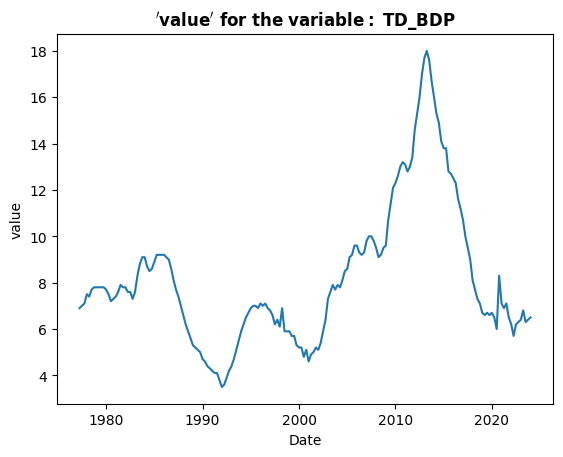

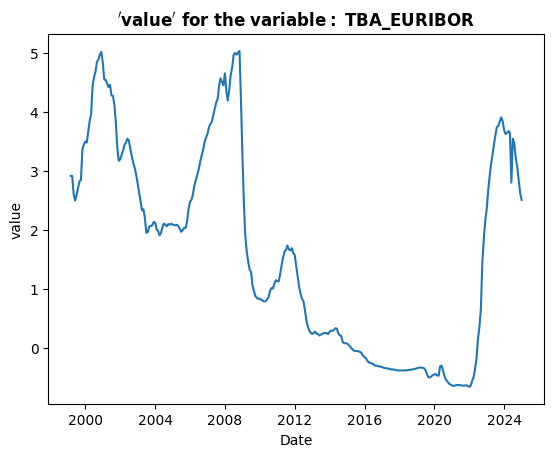

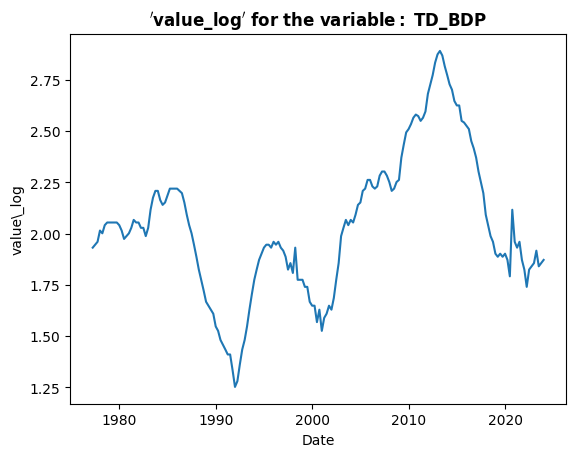

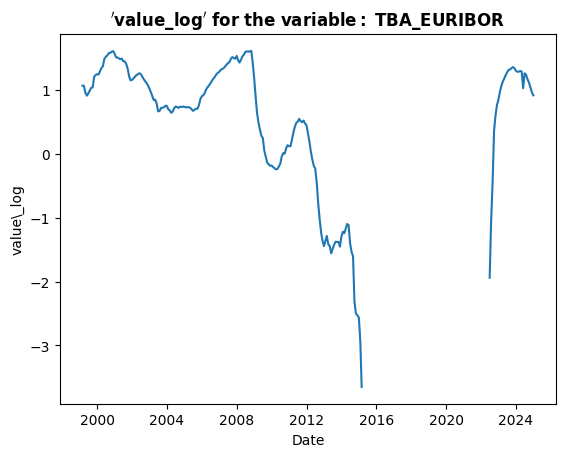

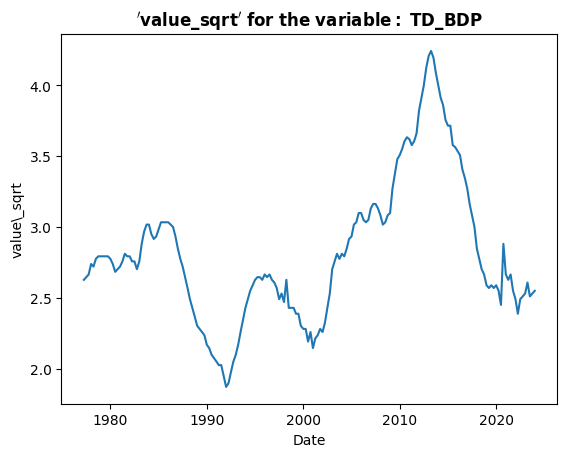

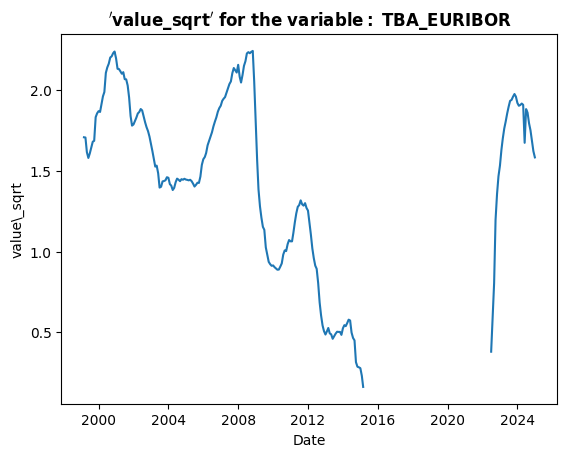

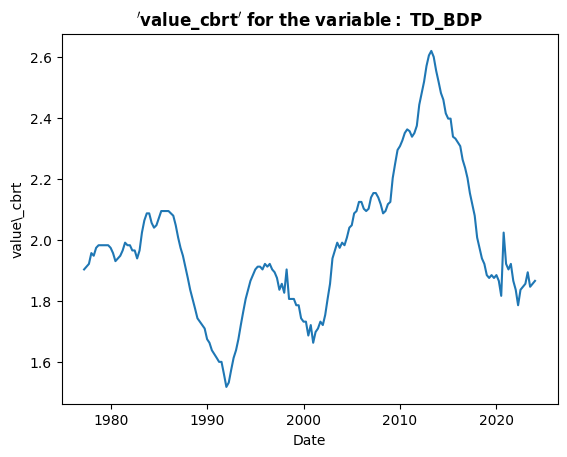

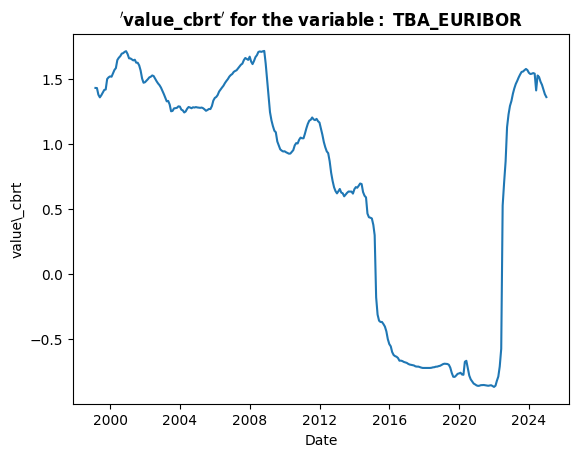

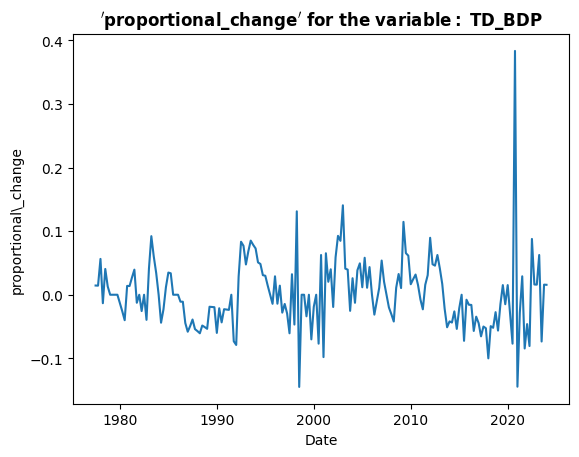

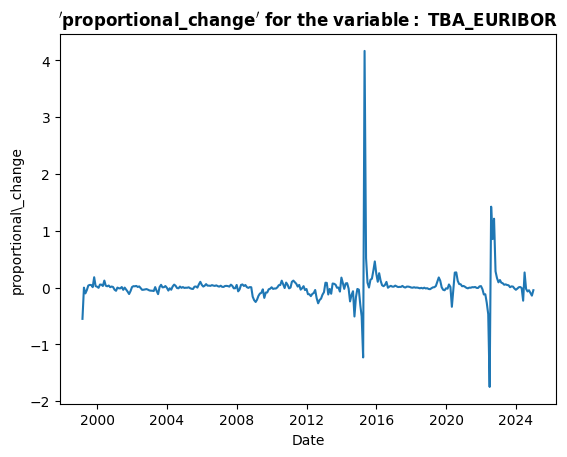

In [ ]:
# --plot to check --
col_list = ['value', 'value_log', 'value_sqrt', 'value_cbrt', 'proportional_change']

for col in col_list:

  for var in ns_variables:
    var_legend = var.replace('_',r'\_')
    col_legend = col.replace('_',r'\_')

    ns_df_var = ns_df[ns_df['Variavel']==var]
    plt.plot(ns_df_var['Date'], ns_df_var[col], label=var)
    plt.xlabel('Date')
    plt.ylabel(f'{col_legend}')
    plt.title(fr"$\mathbf{{ '{col_legend}'\ for\ the\ variable:\ {var_legend}}}$")
    plt.show()

In [ ]:
## --- Re run ADF with transformations applied --

def adf_perform_short(data,var_list, var_column):
  results = []

  for var_id in var_list:
    series = data[var_column].dropna()

    for lag in [0, 1, 2, 3]:
        try:
            adf_result = adfuller(series, maxlag=lag, regression='c', autolag=None)
            results.append({
                'Variable ID': var_id,
                'Lag': lag,
                'ADF Statistic': adf_result[0],
                'p-value': adf_result[1],
                'Used Lag': adf_result[2],
                'N Observations': adf_result[3],
                **{f"CV {k}": v for k, v in adf_result[4].items()}
            })
        except Exception as e:
            print(f"ADF test failed for {var_id} (lag {lag}): {e}")
  return results



results_log = adf_perform_short(ns_df, ns_variable_ids, 'value_log')
results_log_adf = pd.DataFrame(results_log)

results_sqrt = adf_perform_short(ns_df, ns_variable_ids, 'value_sqrt')
results_sqrt_adf = pd.DataFrame(results_sqrt)

results_cbrt = adf_perform_short(ns_df, ns_variable_ids, 'value_cbrt')
results_cbrt_adf = pd.DataFrame(results_cbrt)

results_porp = adf_perform_short(ns_df, ns_variable_ids, 'proportional_change')
results_porp_adf = pd.DataFrame(results_porp)


In [ ]:
# 1. Log Transformation
results_log_adf

,Variable ID,Lag,ADF Statistic,p-value,Used Lag,N Observations,CV 1%,CV 5%,CV 10%
0,12562676,0,-1.399973,0.582289,0,410,-3.446401,-2.868615,-2.570539
1,12562676,1,-1.958387,0.305111,1,409,-3.446440,-2.868633,-2.570548
2,12562676,2,-2.188257,0.210535,2,408,-3.446480,-2.868650,-2.570557
3,12562676,3,-2.553957,0.102892,3,407,-3.446520,-2.868668,-2.570567
4,12504602,0,-1.399973,0.582289,0,410,-3.446401,-2.868615,-2.570539
5,12504602,1,-1.958387,0.305111,1,409,-3.446440,-2.868633,-2.570548
6,12504602,2,-2.188257,0.210535,2,408,-3.446480,-2.868650,-2.570557
7,12504602,3,-2.553957,0.102892,3,407,-3.446520,-2.868668,-2.570567


In [ ]:
# 2. Root Transformation
results_sqrt_adf

,Variable ID,Lag,ADF Statistic,p-value,Used Lag,N Observations,CV 1%,CV 5%,CV 10%
0,12562676,0,-0.975591,0.762063,0,410,-3.446401,-2.868615,-2.570539
1,12562676,1,-1.303548,0.627548,1,409,-3.446440,-2.868633,-2.570548
2,12562676,2,-1.702982,0.429577,2,408,-3.446480,-2.868650,-2.570557
3,12562676,3,-2.035090,0.271402,3,407,-3.446520,-2.868668,-2.570567
4,12504602,0,-0.975591,0.762063,0,410,-3.446401,-2.868615,-2.570539
5,12504602,1,-1.303548,0.627548,1,409,-3.446440,-2.868633,-2.570548
6,12504602,2,-1.702982,0.429577,2,408,-3.446480,-2.868650,-2.570557
7,12504602,3,-2.035090,0.271402,3,407,-3.446520,-2.868668,-2.570567


In [ ]:
results_cbrt_adf

,Variable ID,Lag,ADF Statistic,p-value,Used Lag,N Observations,CV 1%,CV 5%,CV 10%
0,12562676,0,-0.943716,0.773236,0,497,-3.443576,-2.867373,-2.569877
1,12562676,1,-1.217238,0.666137,1,496,-3.443603,-2.867385,-2.569883
2,12562676,2,-1.434906,0.565432,2,495,-3.443630,-2.867397,-2.569889
3,12562676,3,-1.657469,0.453148,3,494,-3.443657,-2.867408,-2.569896
4,12504602,0,-0.943716,0.773236,0,497,-3.443576,-2.867373,-2.569877
5,12504602,1,-1.217238,0.666137,1,496,-3.443603,-2.867385,-2.569883
6,12504602,2,-1.434906,0.565432,2,495,-3.443630,-2.867397,-2.569889
7,12504602,3,-1.657469,0.453148,3,494,-3.443657,-2.867408,-2.569896


In [ ]:
results_porp_adf

,Variable ID,Lag,ADF Statistic,p-value,Used Lag,N Observations,CV 1%,CV 5%,CV 10%
0,12562676,0,-21.896525,0.000000e+00,0,496,-3.443603,-2.867385,-2.569883
1,12562676,1,-15.709483,1.365033e-28,1,495,-3.443630,-2.867397,-2.569889
2,12562676,2,-13.841049,7.291579e-26,2,494,-3.443657,-2.867408,-2.569896
3,12562676,3,-11.519252,4.077992e-21,3,493,-3.443684,-2.867420,-2.569902
4,12504602,0,-21.896525,0.000000e+00,0,496,-3.443603,-2.867385,-2.569883
5,12504602,1,-15.709483,1.365033e-28,1,495,-3.443630,-2.867397,-2.569889
6,12504602,2,-13.841049,7.291579e-26,2,494,-3.443657,-2.867408,-2.569896
7,12504602,3,-11.519252,4.077992e-21,3,493,-3.443684,-2.867420,-2.569902


In [ ]:
## Put table together with info of 3 variables (with label saying weather there was transformation)

pib_var = input_info[input_info['ID_SERIE']==12518314]
pib_var['Variavel'] = 'PIB_PM_TVH'


pib_var['transformed'] = 'No'
pib_var['stationary'] = 'Yes'
ns_df['transformed'] = 'proportional_change'
ns_df['stationary'] = 'No'

table_vars = pd.concat([ns_df, pib_var], ignore_index=True)
table_vars

<ipython-input-16-7d84df3cc805>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pib_var['Variavel'] = 'PIB_PM_TVH'
<ipython-input-16-7d84df3cc805>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pib_var['transformed'] = 'No'
<ipython-input-16-7d84df3cc805>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

,ID_SERIE,Date,value,DATA_UPDT,Variavel,value_log,value_sqrt,value_cbrt,proportional_change,transformed,stationary
0,12562676,1977-03-31,6.9,2025-01-07,TD_BDP,1.931521,2.626785,1.903778,NaN,proportional_change,No
1,12562676,1977-06-30,7.0,2025-01-07,TD_BDP,1.945910,2.645751,1.912931,0.014493,proportional_change,No
2,12562676,1977-09-30,7.1,2025-01-07,TD_BDP,1.960095,2.664583,1.921997,0.014286,proportional_change,No
3,12562676,1977-12-31,7.5,2025-01-07,TD_BDP,2.014903,2.738613,1.957434,0.056338,proportional_change,No
4,12562676,1978-03-31,7.4,2025-01-07,TD_BDP,2.001480,2.720294,1.948695,-0.013333,proportional_change,No
...,...,...,...,...,...,...,...,...,...,...,...
608,12518314,2023-09-30,1.8,2025-01-07,PIB_PM_TVH,NaN,NaN,NaN,NaN,No,Yes
609,12518314,2023-12-31,2.1,2025-01-07,PIB_PM_TVH,NaN,NaN,NaN,NaN,No,Yes
610,12518314,2024-03-31,1.4,2025-01-07,PIB_PM_TVH,NaN,NaN,NaN,NaN,No,Yes
611,12518314,2024-06-30,1.6,2025-01-07,PIB_PM_TVH,NaN,NaN,NaN,NaN,No,Yes


PIB Mean: 1.504
PIB STD: 3.68
PIB Skewness: -0.777
PIB Kurtosis: 7.601
PIB Shapiro Stat: 0.863    p-value: 0.0
PIB KS statistic: 0.5512904607927478     p-value: 2.3026384434178976e-33 



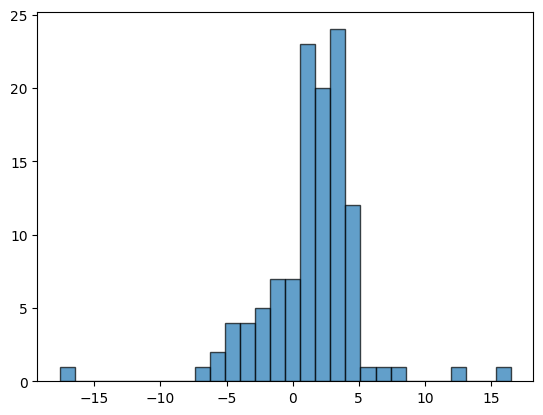

TD Mean: 0.001
TD STD: 0.056
TD Skewness: nan
TD Kurtosis: nan
Shapiro Stat Td: nan    p-value: nan
TD KS statistic: nan     p-value: nan


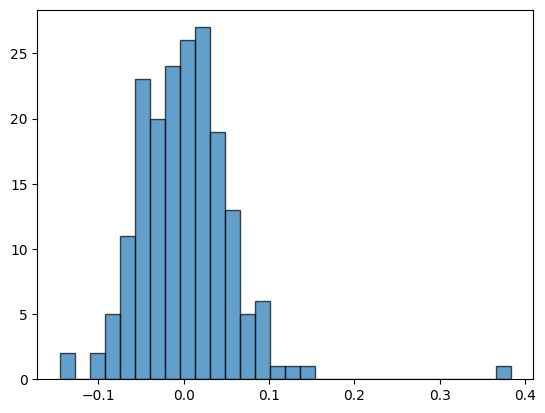

EURIBOR Mean: 0.012
EURIBOR STD: 0.311
EURIBOR Skewness: 7.43
EURIBOR Kurtosis: 107.001
Shapiro Stat Euribor: 0.366    p-value: 0.0
EURIBOR KS statistic: 0.38735014187414063     p-value: 2.225230064897172e-42


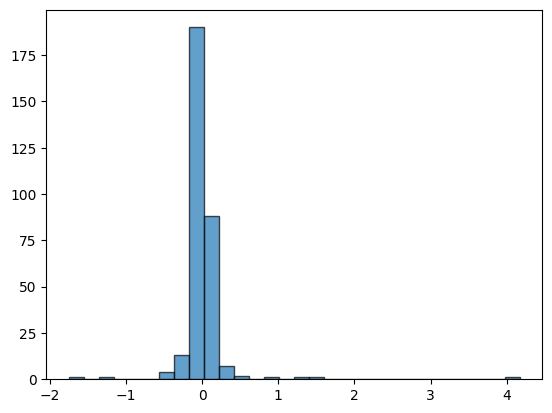

In [ ]:
# --- Check Normalization ---

pib_data = table_vars[table_vars['Variavel']=='PIB_PM_TVH']['value']
td_data=table_vars[table_vars['Variavel']=='TD_BDP']['proportional_change']
euribor_data= table_vars[table_vars['Variavel']=='TBA_EURIBOR']['proportional_change']

n_bins=30

print('PIB Mean:', round(pib_data.mean(),3))
print('PIB STD:', round(pib_data.std(),3))
print('PIB Skewness:', round(skew(pib_data),3))
print('PIB Kurtosis:', round(kurtosis(pib_data),3))
print('PIB Shapiro Stat:',round(stats.shapiro(pib_data)[0], 3) , '   p-value:', round(stats.shapiro(pib_data)[1], 3))

pib_statistic, pib_p_value = kstest(pib_data, 'norm')
print(f"PIB KS statistic: {pib_statistic}    ", f"p-value: {pib_p_value}", '\n')

plt.hist(pib_data, bins=n_bins, edgecolor='black', alpha=0.7)
plt.show()



print('TD Mean:', round(td_data.mean(),3))
print('TD STD:', round(td_data.std(),3))
print('TD Skewness:', round(skew(td_data),3))
print('TD Kurtosis:', round(kurtosis(td_data),3))
print('Shapiro Stat Td:',round(stats.shapiro(td_data)[0], 3) , '   p-value:', round(stats.shapiro(td_data)[1], 3))

td_statistic, td_p_value = kstest(td_data, 'norm')
print(f"TD KS statistic: {td_statistic}    ", f"p-value: {td_p_value}")

plt.hist(td_data, bins=n_bins, edgecolor='black', alpha=0.7)
plt.show()



print('EURIBOR Mean:', round(euribor_data.mean(),3))
print('EURIBOR STD:', round(euribor_data.std(),3))
print('EURIBOR Skewness:', round(skew(euribor_data),3))
print('EURIBOR Kurtosis:', round(kurtosis(euribor_data),3))
print('Shapiro Stat Euribor:',round(stats.shapiro(euribor_data)[0], 3) , '   p-value:', round(stats.shapiro(euribor_data)[1], 3))

euribor_statistic, euribor_p_value = kstest(euribor_data, 'norm')
print(f"EURIBOR KS statistic: {euribor_statistic}    ", f"p-value: {euribor_p_value}")

plt.hist(euribor_data, bins=n_bins, edgecolor='black', alpha=0.7)
plt.show()


In [ ]:
## -- Normalization using median (as data does not appear to follow normal distribution) --

pib_median = pib_data.median()
td_median = td_data.median()
euribor_median = euribor_data.median()

pib_avg = pib_data.mean()
td_avg = td_data.mean()
euribor_avg = euribor_data.mean()


#Add label saying how normalization was made
table_vars['normalization'] = 'Median'


table_vars.loc[table_vars['Variavel']=='PIB_PM_TVH' , 'value_normalized'] = (table_vars['value'] - pib_median)/(abs(table_vars['value'] - pib_avg).median())
table_vars.loc[table_vars['Variavel']=='TD_BDP' , 'value_normalized'] = (table_vars['proportional_change'] - td_median)/(abs(table_vars['proportional_change'] - td_avg).median())
table_vars.loc[table_vars['Variavel']=='TBA_EURIBOR' , 'value_normalized'] = (table_vars['proportional_change'] - euribor_median)/(abs(table_vars['proportional_change'] - euribor_avg).median())

In [ ]:
table_vars

,ID_SERIE,Date,value,DATA_UPDT,Variavel,value_log,value_sqrt,value_cbrt,proportional_change,transformed,stationary,normalization,value_normalized
0,12562676,1977-03-31,6.9,2025-01-07,TD_BDP,1.931521,2.626785,1.903778,NaN,proportional_change,No,Median,NaN
1,12562676,1977-06-30,7.0,2025-01-07,TD_BDP,1.945910,2.645751,1.912931,0.014493,proportional_change,No,Median,0.448615
2,12562676,1977-09-30,7.1,2025-01-07,TD_BDP,1.960095,2.664583,1.921997,0.014286,proportional_change,No,Median,0.442207
3,12562676,1977-12-31,7.5,2025-01-07,TD_BDP,2.014903,2.738613,1.957434,0.056338,proportional_change,No,Median,1.743914
4,12562676,1978-03-31,7.4,2025-01-07,TD_BDP,2.001480,2.720294,1.948695,-0.013333,proportional_change,No,Median,-0.412726
...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,12518314,2023-09-30,1.8,2025-01-07,PIB_PM_TVH,NaN,NaN,NaN,NaN,No,Yes,Median,-0.048231
609,12518314,2023-12-31,2.1,2025-01-07,PIB_PM_TVH,NaN,NaN,NaN,NaN,No,Yes,Median,0.096462
610,12518314,2024-03-31,1.4,2025-01-07,PIB_PM_TVH,NaN,NaN,NaN,NaN,No,Yes,Median,-0.241156
611,12518314,2024-06-30,1.6,2025-01-07,PIB_PM_TVH,NaN,NaN,NaN,NaN,No,Yes,Median,-0.144694


In [ ]:
#Last treatments before saving

table_vars=table_vars.drop(columns=['DATA_UPDT','value_log','value_sqrt','value_cbrt'])
table_vars.rename(columns={'transformed':'transformation' , 'proportional_change':'value_transformed' }, inplace=True)
table_vars = table_vars[['ID_SERIE', 'Variavel',	'Date',	'value', 'stationary','transformation', 'value_transformed'	,	'normalization',	'value_normalized']]
table_vars

,ID_SERIE,Variavel,Date,value,stationary,transformation,value_transformed,normalization,value_normalized
0,12562676,TD_BDP,1977-03-31,6.9,No,proportional_change,NaN,Median,NaN
1,12562676,TD_BDP,1977-06-30,7.0,No,proportional_change,0.014493,Median,0.448615
2,12562676,TD_BDP,1977-09-30,7.1,No,proportional_change,0.014286,Median,0.442207
3,12562676,TD_BDP,1977-12-31,7.5,No,proportional_change,0.056338,Median,1.743914
4,12562676,TD_BDP,1978-03-31,7.4,No,proportional_change,-0.013333,Median,-0.412726
...,...,...,...,...,...,...,...,...,...
608,12518314,PIB_PM_TVH,2023-09-30,1.8,Yes,No,NaN,Median,-0.048231
609,12518314,PIB_PM_TVH,2023-12-31,2.1,Yes,No,NaN,Median,0.096462
610,12518314,PIB_PM_TVH,2024-03-31,1.4,Yes,No,NaN,Median,-0.241156
611,12518314,PIB_PM_TVH,2024-06-30,1.6,Yes,No,NaN,Median,-0.144694


In [ ]:
# Save results
table_vars.to_csv('stats_pib_td_euribor.csv', index=False)